In [1]:
%matplotlib qt

In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [4]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_new_Notched.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

# Calculate the power spectrum density to examine the power in each frequency.
n_MMN_raw.compute_psd(fmin=1, fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
fif_DIR.mkdir(exist_ok=True)

#n_MMN_raw.save(uncut_fif_DIR / Path('eeg_20250610_test_new_MMN_Notched.fif'), overwrite=True)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 524287  =      0.000 ...   511.999 secs...
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 06:53:38 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Channels marked as bad:
['Trigger']


In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [119]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)
n_MMN_raw = mne.io.read_raw_cnt(root_data_path / Path('eeg_20250610_test_new_noNotch.cnt'), eog="header", preload=True)

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

# Get the start points in every 3 segment, staring from index[0]
start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

# Get the end points in every 3 segment, staring from index[2]
end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

# segment the EEG data according to the points that are going to be converted into times, and save the raw EEG files
for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq))-0.2, (end_tNDarray[i][0]/int(raw_sfreq))+0.5)
    cut_eeg.save(fif_DIR / Path('n_%s_new_noNotch.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 553727  =      0.000 ...   540.749 secs...
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[ 15535      0      1]
 [ 75440      0      3]
 [147604      0     11]
 [149648      0      2]
 [212626      0      4]
 [274178      0     11]
 [276211      0      8]
 [342261      0      5]
 [383926      0     11]
 [386140      0      9]
 [458335      0      6]
 [466883      0     11]
 [469104      0     10]
 [538227      0      7]
 [549635      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[ 15535      0      1]
 [149648      0      2]
 [276211      0      8]
 [386140      0      9]
 [469104      0     10]]
5
[[147604

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3459804144.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_eyeOpen_2min_new_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('n_%s_new_noNotch.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3459804144.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_eyeClose_2min_new_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('n_%s_new_noNotch.fif' 

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_HEOG_60count_new_noNotch.fif
[done]
458.109375 536.7529296875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_VEOG_60count_new_noNotch.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_VEOG_60count_new_noNotch.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3459804144.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/n_VEOG_60count_new_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('n_%s_new_noNotch.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

Effective window size : 2.000 (s)


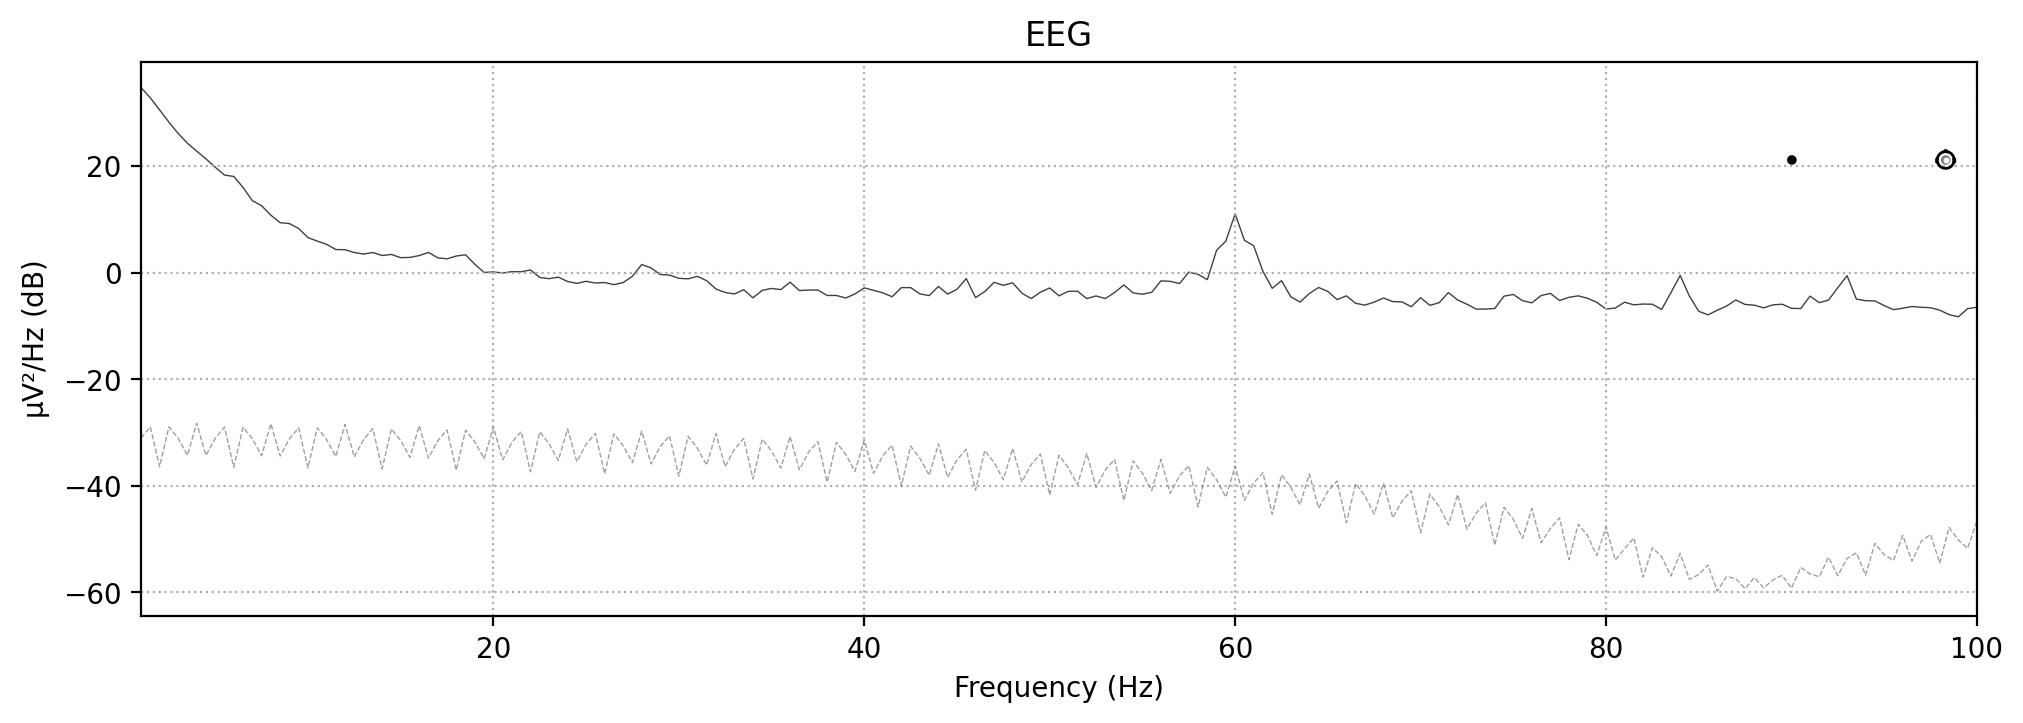

2025-08-22 18:03:51.157 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:55.698 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.323 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.590 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [47]:
raw_MMN_fif.compute_psd(fmin=1, fmax=100).plot()


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif...
    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/1827231909.py:5: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/1827231909.py:15: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif

    Range : 0 ... 410623 =      0.000 ...   400.999 secs
Ready.
Reading 0 ... 410623  =      0.000 ...   400.999 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Effective window size : 2.000 (s)


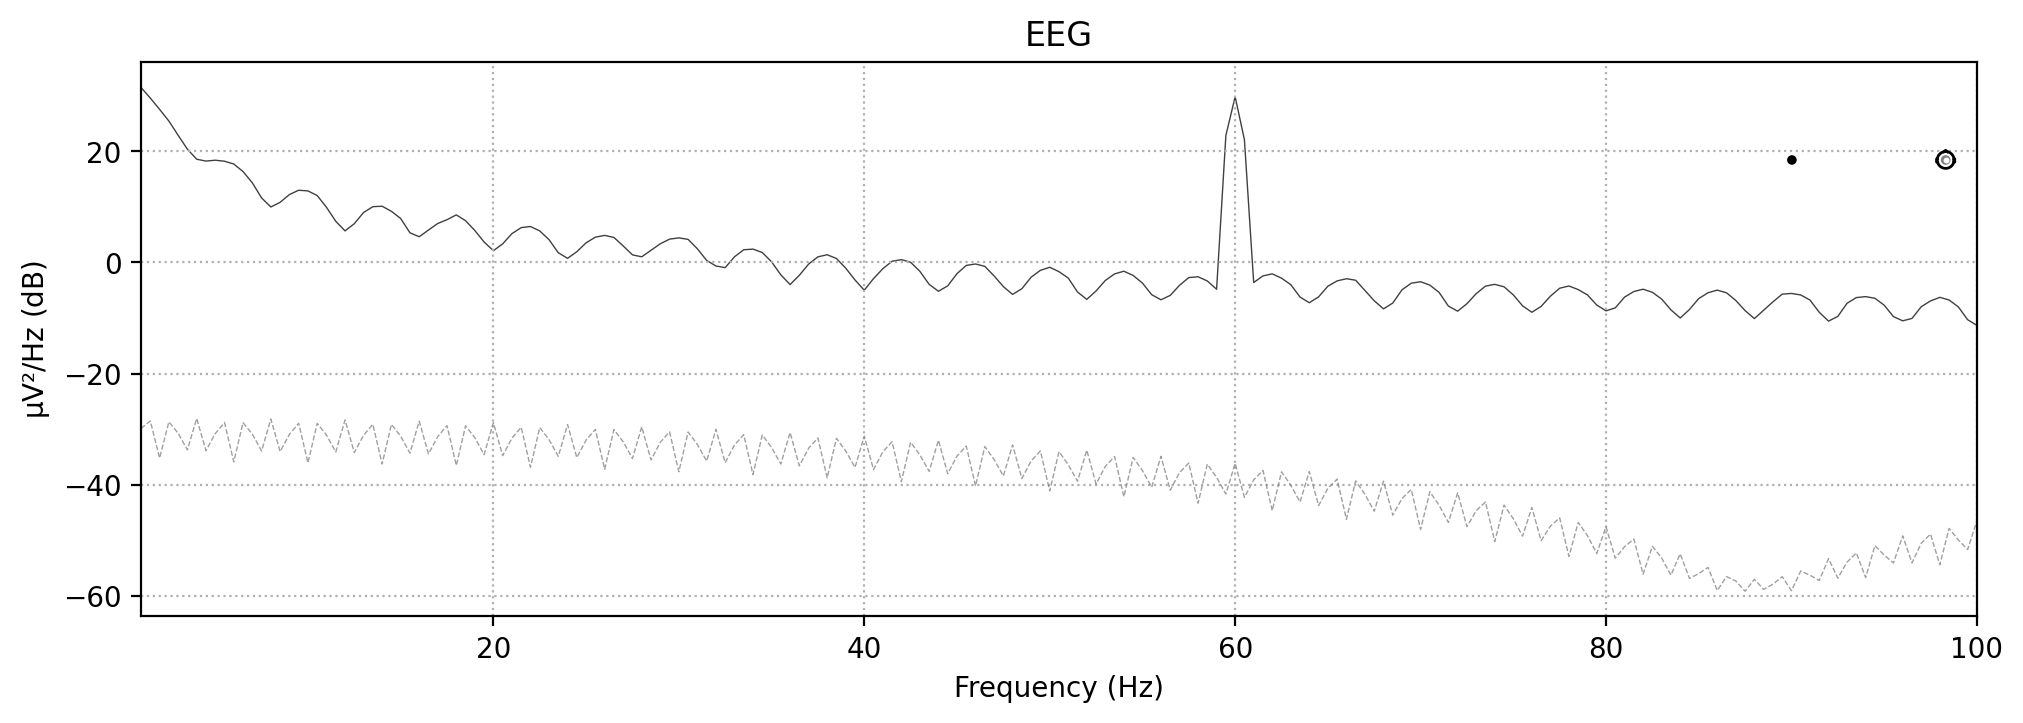

In [4]:
# MMN data analysis
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'

# noNotch
noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
# Check whether the ch exists
print(noNotch_raw_MMN_fif.info['ch_names'])
print(noNotch_raw_MMN_fif.get_channel_types())
# Rename the channels
noNotch_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
noNotch_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})


#Notched
Notched_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_Notched.fif'), preload=True)
# Check whether the ch exists
print(Notched_raw_MMN_fif.info['ch_names'])
print(Notched_raw_MMN_fif.get_channel_types())
# Rename the channels
Notched_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
Notched_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})

merged_MMN_LIST = [noNotch_raw_MMN_fif, Notched_raw_MMN_fif]
#merged_MMN_LIST.plot()

merged_MMN = mne.concatenate_raws(merged_MMN_LIST)
merged_MMN.compute_psd(fmin=1, fmax=100).plot()
#merged_MMN.save(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), overwrite=True)

In [10]:
# Compute the psd of two different kinds of gel
orig_MMN_merged_raw_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)
orig_MMN_psd = orig_MMN_merged_raw_fif.compute_psd(fmin=1, fmax=100).plot()

new_MMN_merged_raw_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('new_MMN_merged_raw.fif'), preload=True)
new_MMN_psd = new_MMN_merged_raw_fif.compute_psd(fmin=1, fmax=100).plot()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/new_MMN_merged_raw.fif...
    Range : 0 ... 825599 =      0.000 ...   806.249 secs
Ready.
Reading 0 ... 825599  =      0.000 ...   806.249 secs...
Effective window size : 2.000 (s)


In [17]:
new_MMN_psd = new_MMN_merged_fif.compute_psd(fmin=1, fmax=70)#.plot()
new_MMN_freqs_ndArray = new_MMN_psd.freqs
new_MMN_power_ndArray = new_MMN_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
new_MMN_avg_power_ndArray = new_MMN_power_ndArray.mean(axis=0)  # mean across epochs

print(new_MMN_psd)
print("=============")
print(new_MMN_freqs_ndArray)
print("=============")
print(new_MMN_power_ndArray)
print("=============")
print(new_MMN_avg_power_ndArray)

alpha_idx = (new_MMN_freqs_ndArray >= 8) & (new_MMN_freqs_ndArray <= 14)
noise_idx = (new_MMN_freqs_ndArray >= 25) & (new_MMN_freqs_ndArray <= 40)  # high-freq muscle-like noise

print(alpha_idx)
print(noise_idx)

Effective window size : 2.000 (s)
<Power Spectrum (from Raw, welch method) | 2 channels × 139 freqs, 1.0-70.0 Hz>
[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5
 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5
 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5
 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5
 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70. ]
[[2.40212197e-09 1.67409085e-09 9.79706928e-10 5.70410390e-10
  3.53178265e-10 2.51487122e-10 1.71111676e-10 1.22220794e-10
  9.14861928e-11 7.62090419e-11 6.31439775e-11 4.2936059

In [ ]:
def flag_bad_psd(epochs, channel_name='Fz_1', threshold_alpha_power=2.0, threshold_noise_ratio=2.0):
    """
    Flags PSDs from one channel for poor signal quality.
    
    Parameters:
    - epochs: MNE Epochs object
    - channel_name: str, name of the EEG channel
    - threshold_alpha_power: float, minimum mean alpha power (μV²/Hz)
    - threshold_noise_ratio: float, max acceptable ratio of noise power to alpha
    
    Returns:
    - flags: dict with boolean flags and values
    """
    import numpy as np

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[alpha_idx].mean()
    noise_power = avg_power[noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

In [ ]:

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[alpha_idx].mean()
    noise_power = avg_power[noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

    flags = {
        'low_alpha_power': alpha_power < threshold_alpha_power,
        'high_noise_ratio': noise_ratio > threshold_noise_ratio,
        'alpha_power': alpha_power,
        'noise_power': noise_power,
        'noise_ratio': noise_ratio
    }

    return flags


In [26]:
# Creating the new epochs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
merged_MMN = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)

# Set the event markers according to the annotations
MMN_eventsArray = mne.events_from_annotations(merged_MMN)[0]
MMN_events = MMN_eventsArray #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

epoch_DIR = fif_DIR / 'MMN_epochs'
merged_MMN.filter(0, 70, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_MMN = mne.Epochs(merged_MMN, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_MMN.info)
#n_epoch_MMN.save(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), overwrite=True)
n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Filtering raw data in 2 contiguous segments
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-12 dB cutoff frequency: 78.75 Hz)
- Filter length: 195 samples (0.190 s)

Not setting metadata
1000 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1000 events and 401 original time poin

Number of events,494
Events,deviant_2: 50deviant_3: 49standard: 395
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


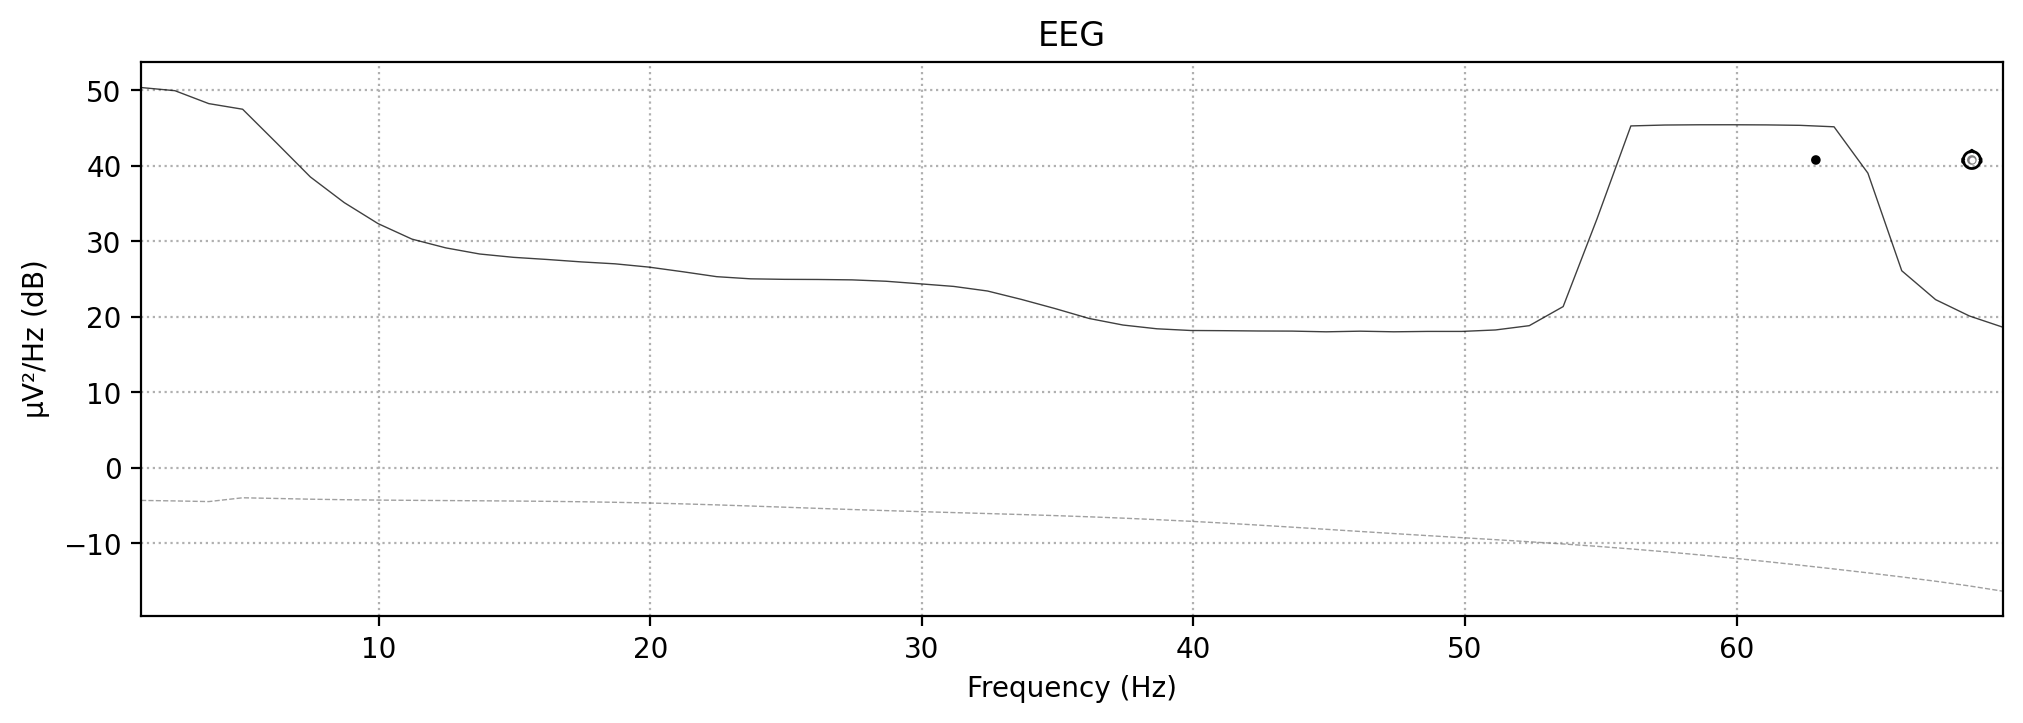

2025-08-23 10:54:52.513 python[38027:21351307] +[CATransaction synchronize] called within transaction


In [27]:
n_epoch_MMN.compute_psd(fmin=1, fmax=70).plot()

In [35]:
# Compute the psd of two different kinds of gel
epoch_DIR = fif_DIR / 'MMN_epochs'
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)
orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)
new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/630693743.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)


Averaging across epochs...
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/630693743.py:6: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)


Averaging across epochs...


In [60]:
# Plot the psd & SNR of the no filter & no resample MMN epoch
import numpy as np

# --- helpers (reuse from earlier) ---
def ensure_2d(P):
    P = np.asarray(P)
    return P[None, :] if P.ndim == 1 else P

def band_mean(P, freqs, fmin, fmax):
    P = ensure_2d(P)
    idx = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(idx):
        raise ValueError(f"No bins in [{fmin}, {fmax}] Hz")
    return P[:, idx].mean(axis=1)

def snr_db_from_psd(P, freqs, signal_band=(1,12), noise_band=(58,62)):
    sig = band_mean(P, freqs, *signal_band)
    noi = band_mean(P, freqs, *noise_band)
    eps = 1e-20
    return 10 * np.log10((sig + eps) / (noi + eps))  # per-epoch SNR(dB)

# Input 2 type of data
epoch_DIR = fif_DIR / 'MMN_epochs'
# Original
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()
# New
#new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

"""
# --- assume you have epochs with event_id: {'standard':1, 'deviant_2':2, ...} ---
# Use your existing object: n_epoch_MMN
epochs_std = orig_MMN_merged_epoch_fif['standard'].copy().baseline((None, 0)).crop(tmin=0.0, tmax=0.4)
epochs_dev = orig_MMN_merged_epoch_fif['deviant_2'].copy().baseline((None, 0)).crop(tmin=0.0, tmax=0.4)

# Compute PSD (multitaper is more stable on short windows)
psd_std = epochs_std.compute_psd(fmin=1, fmax=70, picks='Fz_1')#compute_psd(method='multitaper', fmin=1, fmax=70, picks='Fz_1')
psd_dev = epochs_dev.compute_psd(fmin=1, fmax=70, picks='Fz_1')

freqs = psd_std.freqs
P_std = psd_std.get_data(picks='Fz_1')[0] #np.squeeze(psd_std.get_data(picks='Fz_1'))  # shape: (n_epochs, n_freqs)
P_dev = psd_dev.get_data(picks='Fz_1')[0] #np.squeeze(psd_dev.get_data(picks='Fz_1'))

# SNR per epoch (you can aggregate later)
signal_band = (1, 12)     # ERP-dominated
noise_band  = (58, 62)    # 60 Hz mains neighborhood; adjust if 50 Hz -> (48,52)
snr_std = snr_db_from_psd(P_std, freqs, signal_band, noise_band)  # (n_epochs,)
snr_dev = snr_db_from_psd(P_dev, freqs, signal_band, noise_band)

print(f"Standard SNR (median dB): {np.median(snr_std):.2f}")
print(f"Deviant  SNR (median dB): {np.median(snr_dev):.2f}")
"""

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif ...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/2697024566.py:25: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


TypeError: 'tuple' object is not callable

In [62]:
import numpy as np
import mne

# ---- CONFIG ----
channel     = 'Fz_1'       # adjust if needed
std_key     = 'standard'   # your event/condition name
dev_key     = 'deviant_2'  # or 'deviant_3', etc.
crop_psd    = (0.0, 0.40)  # post-stim window for PSD
fmin, fmax  = 1, 70
signal_band = (1, 12)      # ERP-ish band; use (8,12) if you want alpha
noise_band  = (58, 62)     # Taiwan = 60 Hz; use (48,52) for 50 Hz mains
EPS         = 1e-20

# Input 2 type of data
epoch_DIR = fif_DIR / 'MMN_epochs'
# Original
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()
# New
#new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

# ---- pick the two conditions from your Epochs ----
epochs_std = orig_MMN_merged_epoch_fif[std_key].copy()
epochs_dev = orig_MMN_merged_epoch_fif[dev_key].copy()

# baseline *method* (not attribute), then crop
epochs_std.apply_baseline(baseline=(None, 0))
epochs_dev.apply_baseline(baseline=(None, 0))
epochs_std.crop(*crop_psd)
epochs_dev.crop(*crop_psd)

# quick safety: ensure channel exists
if channel not in epochs_std.ch_names:
    raise ValueError(f"Channel {channel!r} not found. Available: {epochs_std.ch_names}")

# ---- PSD per epoch (linear µV²/Hz) ----
psd_std = epochs_std.compute_psd(fmin=fmin, fmax=fmax, picks=channel) #(method='multitaper', fmin=fmin, fmax=fmax, picks=channel)
psd_dev = epochs_dev.compute_psd(fmin=fmin, fmax=fmax, picks=channel) #(method='multitaper', fmin=fmin, fmax=fmax, picks=channel)

freqs = psd_std.freqs
P_std = np.squeeze(psd_std.get_data(picks=channel))  # shape: (n_epochs, n_freqs)
P_dev = np.squeeze(psd_dev.get_data(picks=channel))

# mean PSD for plotting (convert to dB later if you want)
P_std_mean = P_std.mean(axis=0)
P_dev_mean = P_dev.mean(axis=0)

# ---- SNR(dB) per epoch: 10*log10( mean(signal_band) / mean(noise_band) ) ----
def band_mean(P, freqs, band):
    idx = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(idx):
        raise ValueError(f"No frequency bins in band {band}")
    return P[:, idx].mean(axis=1)

sig_std = band_mean(P_std, freqs, signal_band)
sig_dev = band_mean(P_dev, freqs, signal_band)
noi_std = band_mean(P_std, freqs, noise_band)
noi_dev = band_mean(P_dev, freqs, noise_band)

snr_std_db = 10*np.log10((sig_std + EPS) / (noi_std + EPS))  # vectors (n_epochs,)
snr_dev_db = 10*np.log10((sig_dev + EPS) / (noi_dev + EPS))

print(f"Standard SNR (median dB): {np.median(snr_std_db):.2f}")
print(f"Deviant  SNR (median dB): {np.median(snr_dev_db):.2f}")


Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3932817341.py:17: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Standard SNR (median dB): -9.23
Deviant  SNR (median dB): -10.32


In [63]:


import numpy as np
import matplotlib.pyplot as plt
import mne

# ----------- CONFIG -----------
channel     = 'Fz_1'      # change if your channel label differs
std_key     = 'standard'  # your standard condition name
dev_key     = 'deviant_2' # your deviant condition name (or 'deviant_3', etc.)

# spectral settings
crop_psd    = (0.0, 0.40)  # seconds; post-stimulus window for PSD
fmin, fmax  = 1, 70        # PSD range
signal_band = (8, 12)      # alpha for SNR demo; change to (1,12) for ERP-y band
noise_band  = (58, 62)     # 60 Hz region (use (48,52) in 50 Hz regions)
EPS         = 1e-20

# Input 2 type of data
epoch_DIR = fif_DIR / 'MMN_epochs'
# Original
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()
# New
#new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

# ---- pick the two conditions from your Epochs ----
epochs_std = orig_MMN_merged_epoch_fif[std_key].copy()
epochs_dev = orig_MMN_merged_epoch_fif[dev_key].copy()

# baseline *method* (not attribute), then crop
epochs_std.apply_baseline(baseline=(None, 0))
epochs_dev.apply_baseline(baseline=(None, 0))
epochs_std.crop(*crop_psd)
epochs_dev.crop(*crop_psd)

# ----------- PSD (per-epoch) -----------
psd_std = epochs_std.compute_psd(fmin=fmin, fmax=fmax, picks=channel) #(method='multitaper', fmin=fmin, fmax=fmax, picks=channel)
psd_dev = epochs_dev.compute_psd(fmin=fmin, fmax=fmax, picks=channel)

freqs   = psd_std.freqs
P_std   = np.squeeze(psd_std.get_data(picks=channel))  # (n_epochs, n_freqs)
P_dev   = np.squeeze(psd_dev.get_data(picks=channel))  # (n_epochs, n_freqs)

# Average PSD across epochs for plotting (linear µV^2/Hz)
P_std_mean = P_std.mean(axis=0)
P_dev_mean = P_dev.mean(axis=0)

# Convert to dB for plotting
Pdb_std = 10*np.log10(np.maximum(P_std_mean, EPS))
Pdb_dev = 10*np.log10(np.maximum(P_dev_mean, EPS))

# ----------- Alpha SNR(dB) per epoch -----------
def band_mean(P, freqs, band):
    idx = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(idx):
        raise ValueError(f"No frequency bins in band {band}")
    return P[:, idx].mean(axis=1)  # (n_epochs,)

sig_std = band_mean(P_std, freqs, signal_band)
sig_dev = band_mean(P_dev, freqs, signal_band)
noi_std = band_mean(P_std, freqs, noise_band)
noi_dev = band_mean(P_dev, freqs, noise_band)

snr_std_db = 10*np.log10((sig_std + EPS) / (noi_std + EPS))  # (n_epochs,)
snr_dev_db = 10*np.log10((sig_dev + EPS) / (noi_dev + EPS))

# ----------- PLOT: top PSD(dB) + bottom SNR(dB) -----------
fig = plt.figure(figsize=(10.5, 7))
gs  = fig.add_gridspec(2, 1, height_ratios=[2.2, 1.0], hspace=0.30)

# Top: PSD in dB
ax = fig.add_subplot(gs[0])
ax.plot(freqs, Pdb_std, color='#1f77b4', label=f'{std_key} (mean PSD)')
ax.plot(freqs, Pdb_dev, color='#d62728', label=f'{dev_key} (mean PSD)')

# Shade bands
ax.axvspan(signal_band[0], signal_band[1], color='gray', alpha=0.15, label='Signal band')
ax.axvspan(noise_band[0],  noise_band[1],  color='red',  alpha=0.08, label='Noise band')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB, µV²/Hz)')
ax.set_title(f'PSD in dB at {channel} (window {crop_psd[0]:.2f}–{crop_psd[1]:.2f}s)')
# de-duplicate legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='best', fontsize=9)
ax.grid(True, ls='--', alpha=0.4)

# Bottom: Alpha SNR bars
axb = fig.add_subplot(gs[1])
conds    = [f'{std_key}', f'{dev_key}']
snr_means = [snr_std_db.mean(), snr_dev_db.mean()]
snr_sems  = [snr_std_db.std(ddof=1)/np.sqrt(len(snr_std_db)),
             snr_dev_db.std(ddof=1)/np.sqrt(len(snr_dev_db))]
colors   = ['#1f77b4', '#d62728']

bars = axb.bar(conds, snr_means, yerr=snr_sems, capsize=4, color=colors)
axb.set_ylabel(f'SNR (dB)  signal={signal_band[0]}–{signal_band[1]} Hz; noise={noise_band[0]}–{noise_band[1]} Hz')
axb.set_title('Alpha SNR by condition')
axb.grid(axis='y', alpha=0.3)

# annotate bars
for b, v in zip(bars, snr_means):
    axb.text(b.get_x() + b.get_width()/2, b.get_height()+0.15, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif ...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/405471458.py:20: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/405471458.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [73]:
# SNR & PSD for 3 types of sounds
# 1) PSD in dB (top) + Alpha‑band SNR(dB) bars (bottom): Standard vs Deviant
"""
It:

runs the same baseline → crop → PSD pipeline for standard, deviant_2, deviant_3,

plots all three mean PSDs in dB (top),

and shows alpha SNR(dB) bars for all three (bottom).
"""

import numpy as np
import matplotlib.pyplot as plt
import mne

# ----------- CONFIG -----------
channel     = 'Fz_1'
cond_keys   = ['standard', 'deviant_2', 'deviant_3']  # <— now includes deviant_3

# spectral settings
crop_psd    = (-0.1, 0.70)    # seconds; post-stimulus window for PSD
fmin, fmax  = 1, 100          # PSD range
signal_band = (8, 12)        # alpha band for SNR demo (use (1,12) for ERP-y band)
noise_band  = (55, 65)       # 60 Hz region; use (48,52) for 50 Hz
EPS         = 1e-20

# ----------- LOAD EPOCHS -----------
epoch_DIR = fif_DIR / 'MMN_epochs'
orig_MMN_merged_epoch_fif = mne.read_epochs(
    epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True
)

# ----------- PREP & PSD PER CONDITION -----------
psd_dict_lin = {}   # mean linear PSD (µV^2/Hz) per condition (1D: n_freqs)
snr_dict_db  = {}   # SNR(dB) per epoch per condition (1D: n_epochs)
freqs = None

def band_mean(P, freqs, band):
    idx = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(idx):
        raise ValueError(f"No frequency bins in band {band}")
    return P[:, idx].mean(axis=1)  # (n_epochs,)

for key in cond_keys:
    if key not in orig_MMN_merged_epoch_fif.event_id:
        raise ValueError(f"Condition {key!r} not found in epochs. "
                         f"Available: {list(orig_MMN_merged_epoch_fif.event_id.keys())}")

    epochs = orig_MMN_merged_epoch_fif[key].copy()
    # baseline (method) then crop
    epochs.apply_baseline(baseline=(None, 0))
    epochs.crop(*crop_psd)

    if channel not in epochs.ch_names:
        raise ValueError(f"Channel {channel!r} not found. Available: {epochs.ch_names}")

    # PSD (per-epoch, linear µV^2/Hz)
    psd = epochs.compute_psd(fmin=fmin, fmax=fmax, picks=channel)  # method='multitaper' optional
    if freqs is None:
        freqs = psd.freqs
    else:
        # sanity check: identical grids; if not, you can interpolate here
        if not np.array_equal(freqs, psd.freqs):
            raise ValueError("Frequency grids differ across conditions—interpolate to a common grid.")

    P = np.squeeze(psd.get_data(picks=channel))   # (n_epochs, n_freqs)
    psd_dict_lin[key] = P.mean(axis=0)            # store mean spectrum (n_freqs,)

    # SNR(dB) per epoch
    sig = band_mean(P, freqs, signal_band)
    noi = band_mean(P, freqs, noise_band)
    snr_dict_db[key] = 10*np.log10((sig + EPS) / (noi + EPS))  # (n_epochs,)

# ----------- PLOT: top PSD(dB), bottom SNR(dB) -----------
# colors per condition (adjust as you like)
color_map = {
    'standard':  '#1f77b4',  # blue
    'deviant_2': '#d62728',  # red
    'deviant_3': '#2ca02c',  # green
}

fig = plt.figure(figsize=(10.8, 7))
gs  = fig.add_gridspec(2, 1, height_ratios=[2.2, 1.0], hspace=0.30)

# --- Top: PSD in dB ---
ax = fig.add_subplot(gs[0])
for key in cond_keys:
    P_lin = psd_dict_lin[key]
    P_db  = 10*np.log10(np.maximum(P_lin, EPS))
    ax.plot(freqs, P_db, color=color_map.get(key, 'black'), label=f'{key} (mean PSD)')

# Shade bands
ax.axvspan(signal_band[0], signal_band[1], color='gray', alpha=0.15, label='Signal band')
ax.axvspan(noise_band[0],  noise_band[1],  color='red',  alpha=0.08, label='Noise band')

ax.set_xlim(freqs[0], freqs[-1])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB, µV²/Hz)')
ax.set_title(f'PSD in dB at {channel} (window {crop_psd[0]:.2f}–{crop_psd[1]:.2f}s)')
# De-duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='best', fontsize=9)
ax.grid(True, ls='--', alpha=0.4)

# --- Bottom: Alpha SNR bars ---
axb = fig.add_subplot(gs[1])
conds     = cond_keys
snr_means = [snr_dict_db[k].mean() for k in conds]
snr_sems  = [snr_dict_db[k].std(ddof=1)/np.sqrt(len(snr_dict_db[k])) for k in conds]
bar_colors = [color_map.get(k, 'black') for k in conds]

bars = axb.bar(conds, snr_means, yerr=snr_sems, capsize=4, color=bar_colors)
axb.set_ylabel(f'SNR (dB)  signal={signal_band[0]}–{signal_band[1]} Hz; noise={noise_band[0]}–{noise_band[1]} Hz')
axb.set_title('Alpha SNR by condition')
axb.grid(axis='y', alpha=0.3)

# annotate bars
for b, v in zip(bars, snr_means):
    axb.text(b.get_x() + b.get_width()/2, b.get_height()+0.15, f'{v:.1f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3029924636.py:30: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3029924636.py:53: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.epochs.EpochsFIF'>.tmin (-0.0996094 s)
  epochs.crop(*crop_psd)


Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3029924636.py:53: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.epochs.EpochsFIF'>.tmin (-0.0996094 s)
  epochs.crop(*crop_psd)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3029924636.py:53: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.epochs.EpochsFIF'>.tmin (-0.0996094 s)
  epochs.crop(*crop_psd)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3029924636.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2025-08-24 20:43:38.317 python[53445:21745366] +[CATransaction synchronize] called within transaction


In [71]:
#(XWe are not using this for now) 2) ERP waveforms (standard, deviant, difference) with 100–250 ms window shaded + ERP‑SNR in legend
import numpy as np
import matplotlib.pyplot as plt
import mne

# ----------- CONFIG -----------
channel     = 'Fz_1'
std_key     = 'standard'
dev_key     = 'deviant_2'   # or your deviant label
mmn_window  = (0.10, 0.25)  # seconds (adjust to your paradigm)

# Input 2 type of data
epoch_DIR = fif_DIR / 'MMN_epochs'
# Original
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()
# New
#new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)
#new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()
"""
# Use full epoch (already baseline-corrected above)
epochs_std_full = orig_MMN_merged_epoch_fif[std_key].copy().baseline((None, 0))
epochs_dev_full = orig_MMN_merged_epoch_fif[dev_key].copy().baseline((None, 0))
"""
# ---- pick the two conditions from your Epochs ----
epochs_std_full = orig_MMN_merged_epoch_fif[std_key].copy()
epochs_dev_full = orig_MMN_merged_epoch_fif[dev_key].copy()

# baseline *method* (not attribute), then crop
epochs_std_full.apply_baseline(baseline=(None, 0))
epochs_dev_full.apply_baseline(baseline=(None, 0))

# Evoked (ERP) and MMN difference
ev_std = epochs_std_full.average(picks=channel)
ev_dev = epochs_dev_full.average(picks=channel)
mmn_ev = mne.combine_evoked([ev_dev, ev_std], weights=[1, -1])  # dev - std

# Trial-wise arrays for SNR
X_std = epochs_std_full.get_data(picks=channel)[:, 0, :]  # (n_epochs, n_times)
X_dev = epochs_dev_full.get_data(picks=channel)[:, 0, :]  # (n_epochs, n_times)

times = ev_std.times
win   = (times >= mmn_window[0]) & (times <= mmn_window[1])

# ERP-SNR definition: mean(|ERP|) / std(trials) over the window
erp_std = ev_std.data[0, :]  # (n_times,)
erp_dev = ev_dev.data[0, :]
erp_mmn = mmn_ev.data[0, :]

noise_std = X_std.std(axis=0, ddof=1)
noise_dev = X_dev.std(axis=0, ddof=1)
# For MMN noise, use dev minus mean standard per trial:
X_mmn = X_dev - X_std.mean(axis=0, keepdims=True)  # (n_dev, n_times)
noise_mmn = X_mmn.std(axis=0, ddof=1)

EPS = 1e-12
snr_std_win = (np.abs(erp_std[win]).mean()) / (noise_std[win].mean() + EPS)
snr_dev_win = (np.abs(erp_dev[win]).mean()) / (noise_dev[win].mean() + EPS)
snr_mmn_win = (np.abs(erp_mmn[win]).mean()) / (noise_mmn[win].mean() + EPS)

# ----------- PLOT -----------
plt.figure(figsize=(10, 5))
plt.plot(times, erp_std, color='#1f77b4', label=f'{std_key}  (SNR={snr_std_win:.2f})')
plt.plot(times, erp_dev, color='#d62728', label=f'{dev_key}  (SNR={snr_dev_win:.2f})')
plt.plot(times, erp_mmn, color='black',   label=f'Dev−Std  (SNR={snr_mmn_win:.2f})', linewidth=2)

# shade MMN window
plt.axvspan(mmn_window[0], mmn_window[1], color='gray', alpha=0.15, label='MMN window')

plt.axhline(0, color='k', linewidth=0.8, alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP at {channel} with MMN Window and ERP‑SNR')
# de-duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='best', fontsize=9)
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif ...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/1299727441.py:15: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [48]:
def flag_bad_psd(epochs, channel_name='Fz_1', threshold_alpha_power=2.0, threshold_noise_ratio=2.0):
    """
    Flags PSDs from one channel for poor signal quality.
    
    Parameters:
    - epochs: MNE Epochs object
    - channel_name: str, name of the EEG channel
    - threshold_alpha_power: float, minimum mean alpha power (μV²/Hz)
    - threshold_noise_ratio: float, max acceptable ratio of noise power to alpha
    
    Returns:
    - flags: dict with boolean flags and values
    """
    import numpy as np

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[0, alpha_idx].mean()
    noise_power = avg_power[0, noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

    print(alpha_power)
    print(noise_power)
    print(noise_ratio)
    
    flags = {
        'low_alpha_power': alpha_power < threshold_alpha_power,
        'high_noise_ratio': noise_ratio > threshold_noise_ratio,
        'alpha_power': alpha_power,
        'noise_power': noise_power,
        'noise_ratio': noise_ratio
    }

    return flags


In [49]:
orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
print(orig_psd)
new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)
print(new_psd)

Effective window size : 0.802 (s)
1.6983936658867853e-12
3.4341569045428677e-13
3.434151072002439e-07
{'low_alpha_power': True, 'high_noise_ratio': False, 'alpha_power': 1.6983936658867853e-12, 'noise_power': 3.4341569045428677e-13, 'noise_ratio': 3.434151072002439e-07}
Effective window size : 0.802 (s)
6.218085360138811e-12
9.55619029461807e-13
9.556130873780585e-07
{'low_alpha_power': True, 'high_noise_ratio': False, 'alpha_power': 6.218085360138811e-12, 'noise_power': 9.55619029461807e-13, 'noise_ratio': 9.556130873780585e-07}


In [61]:
#orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
epoch_DIR = fif_DIR / 'MMN_epochs'
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)
orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70) #.plot()
orig_MMN_epoch_freqs = orig_MMN_epoch_psd.freqs
orig_MMN_epoch_power = orig_MMN_epoch_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
orig_MMN_epoch_avg_power = orig_MMN_epoch_power.mean(axis=0)  # mean across epochs

# Define frequency bands
alpha_idx = (orig_MMN_epoch_freqs >= 8) & (orig_MMN_epoch_freqs <= 12)
noise_idx = (orig_MMN_epoch_freqs >= 25) & (orig_MMN_epoch_freqs <= 40)  # high-freq muscle-like noise

#alpha_power = orig_MMN_epoch_avg_power[alpha_idx].mean()
# Correct indexing: channel 0, frequencies masked by alpha_idx
alpha_power = orig_MMN_epoch_avg_power[0, alpha_idx].mean()

noise_power = orig_MMN_epoch_avg_power[0, noise_idx].mean()
noise_ratio = noise_power / (alpha_power + 1e-6)

#print(alpha_power)
#print(noise_power)
#print(noise_ratio)

orig_hz60_idx = np.argmin(np.abs(orig_MMN_epoch_freqs - 60))
orig_power_60hz = orig_MMN_epoch_avg_power[0, orig_hz60_idx]
orig_noise_ratio = orig_power_60hz  / (alpha_power + 1e-6)

print(orig_noise_ratio)
"""
# Assuming `freqs` and `avg_power` from compute_psd
hz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin
power_60hz = avg_power[hz60_idx]
"""
#new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3823832688.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)


Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
0.03501083079366626


'\n# Assuming `freqs` and `avg_power` from compute_psd\nhz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin\npower_60hz = avg_power[hz60_idx]\n'

In [60]:
#orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
epoch_DIR = fif_DIR / 'MMN_epochs'
new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)
new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70) #.plot()
new_MMN_epoch_freqs = new_MMN_epoch_psd.freqs
new_MMN_epoch_power = new_MMN_epoch_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
new_MMN_epoch_avg_power = new_MMN_epoch_power.mean(axis=0)  # mean across epochs

# Define frequency bands
new_alpha_idx = (new_MMN_epoch_freqs >= 8) & (new_MMN_epoch_freqs <= 12)
new_noise_idx = (new_MMN_epoch_freqs >= 25) & (new_MMN_epoch_freqs <= 40)  # high-freq muscle-like noise

#alpha_power = orig_MMN_epoch_avg_power[alpha_idx].mean()
# Correct indexing: channel 0, frequencies masked by alpha_idx
new_alpha_power = new_MMN_epoch_avg_power[0, new_alpha_idx].mean()

new_noise_power = new_MMN_epoch_avg_power[0, new_noise_idx].mean()
new_noise_ratio = new_noise_power / (new_alpha_power + 1e-6)

#print(alpha_power)
#print(noise_power)
#print(noise_ratio)

new_hz60_idx = np.argmin(np.abs(new_MMN_epoch_freqs - 60))
new_power_60hz = new_MMN_epoch_avg_power[0, new_hz60_idx]
new_noise_ratio = new_power_60hz  / (new_alpha_power + 1e-6)

print(new_noise_ratio)
"""
# Assuming `freqs` and `avg_power` from compute_psd
hz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin
power_60hz = avg_power[hz60_idx]
"""
#new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/410642964.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)


0.006256767543514173


'\n# Assuming `freqs` and `avg_power` from compute_psd\nhz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin\npower_60hz = avg_power[hz60_idx]\n'

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=[orig_noise_ratio, new_noise_ratio], palette="pastel")
plt.xticks([0, 1], ['Gel A', 'Gel B'])
plt.ylabel('Power at 60 Hz (μV²/Hz)')
plt.title('60 Hz Line Noise Power by Gel Type')
plt.show()

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/573799708.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=[orig_noise_ratio, new_noise_ratio], palette="pastel")


In [101]:
# Recalculate the merged MMN's evoked
epoch_DIR = fif_DIR / 'MMN_epochs'
epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)

fig_DIR = root_data_path / 'figs'
MMN_figs_DIR = fig_DIR / 'MMN_figs'

epoch_DIR.mkdir(exist_ok=True)
fig_DIR.mkdir(exist_ok=True)
MMN_figs_DIR.mkdir(exist_ok=True)

# epochs to evoked
evoked_standard = epoch_MMN['standard'].average()
evoked_deviant_2 = epoch_MMN['deviant_2'].average()
evoked_deviant_3 = epoch_MMN['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mmn_fig = mne.viz.plot_compare_evokeds(tmp, colors = colors) #, axes = 'topo')
#mmn_plot

"""
# Save fig
fig_DIR = root_data_path / 'MMN_figs'
fig_DIR.mkdir(exist_ok=True)
mmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)
"""
#plt.savefig(meg_data_path / Path('H-minus-L_evoked_topomap.png'), overwrite=True). # Check this later

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/192725831.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


"\n# Save fig\nfig_DIR = root_data_path / 'MMN_figs'\nfig_DIR.mkdir(exist_ok=True)\nmmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)\n"

2025-08-22 21:36:05.108 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [107]:
print(n_epoch_MMN.drop_log())
n_epoch_MMN.plot_drop_log()

TypeError: 'tuple' object is not callable

In [104]:
# Use Amplitude-Based Heuristics

new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)
orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)
new_data = new_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel
orig_data = orig_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel

new_peak_to_peak = new_data.max() - new_data.min()
orig_peak_to_peak = orig_data.max() - orig_data.min()

print(f"New Peak-to-peak amplitude: {new_peak_to_peak*1e6:.2f} µV")
print(f"Orignal Peak-to-peak amplitude: {orig_peak_to_peak*1e6:.2f} µV")

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)


Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
New Peak-to-peak amplitude: 39.34 µV
Orignal Peak-to-peak amplitude: 39.47 µV


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)


'\n# Compute Variance or SNR as Proxy for Conductivity\nepochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=0.8, preload=True)\ndata = epochs.get_data(picks=\'Fz_1\')\nvariances = data.var(axis=2).flatten()\nprint(f"Variance across trials: {variances.mean():.2e} µV²")\n'

In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())


## Close Eye & Open Eyes. (Brainwaves)

In [5]:
# Datapath setting
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)
# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
fiveTask_fif_DIR = fif_DIR / '5Tasks'
epoch_DIR = fif_DIR / 'MMN_epochs'
fig_DIR = root_data_path / 'figs'
fiveTask_figs_DIR = fig_DIR / '5tasks_figs'

fif_DIR.mkdir(exist_ok=True)
epoch_DIR.mkdir(exist_ok=True)
fig_DIR.mkdir(exist_ok=True)
fiveTask_figs_DIR.mkdir(exist_ok=True)

/Users/neuroling/Downloads/20250610_EEG-Demo


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/n_eyeOpen_2min_new_noNotch.fif...
    Range : 15330 ... 148116 =     14.971 ...   144.645 secs
Ready.


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/1864527674.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/n_eyeOpen_2min_new_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  noNotch_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR/ Path('n_eyeOpen_2min_new_noNotch.fif'), preload=True)


Reading 0 ... 132786  =      0.000 ...   129.674 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/n_eyeOpen_2min_new_Notched.fif...
    Range : 8539 ... 144643 =      8.339 ...   141.253 secs
Ready.
Reading 0 ... 136104  =      0.000 ...   132.914 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Effective window size : 2.000 (s)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/1864527674.py:14: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/n_eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  Notched_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR / Path('n_eyeOpen_2min_new_Notched.fif'), preload=True)


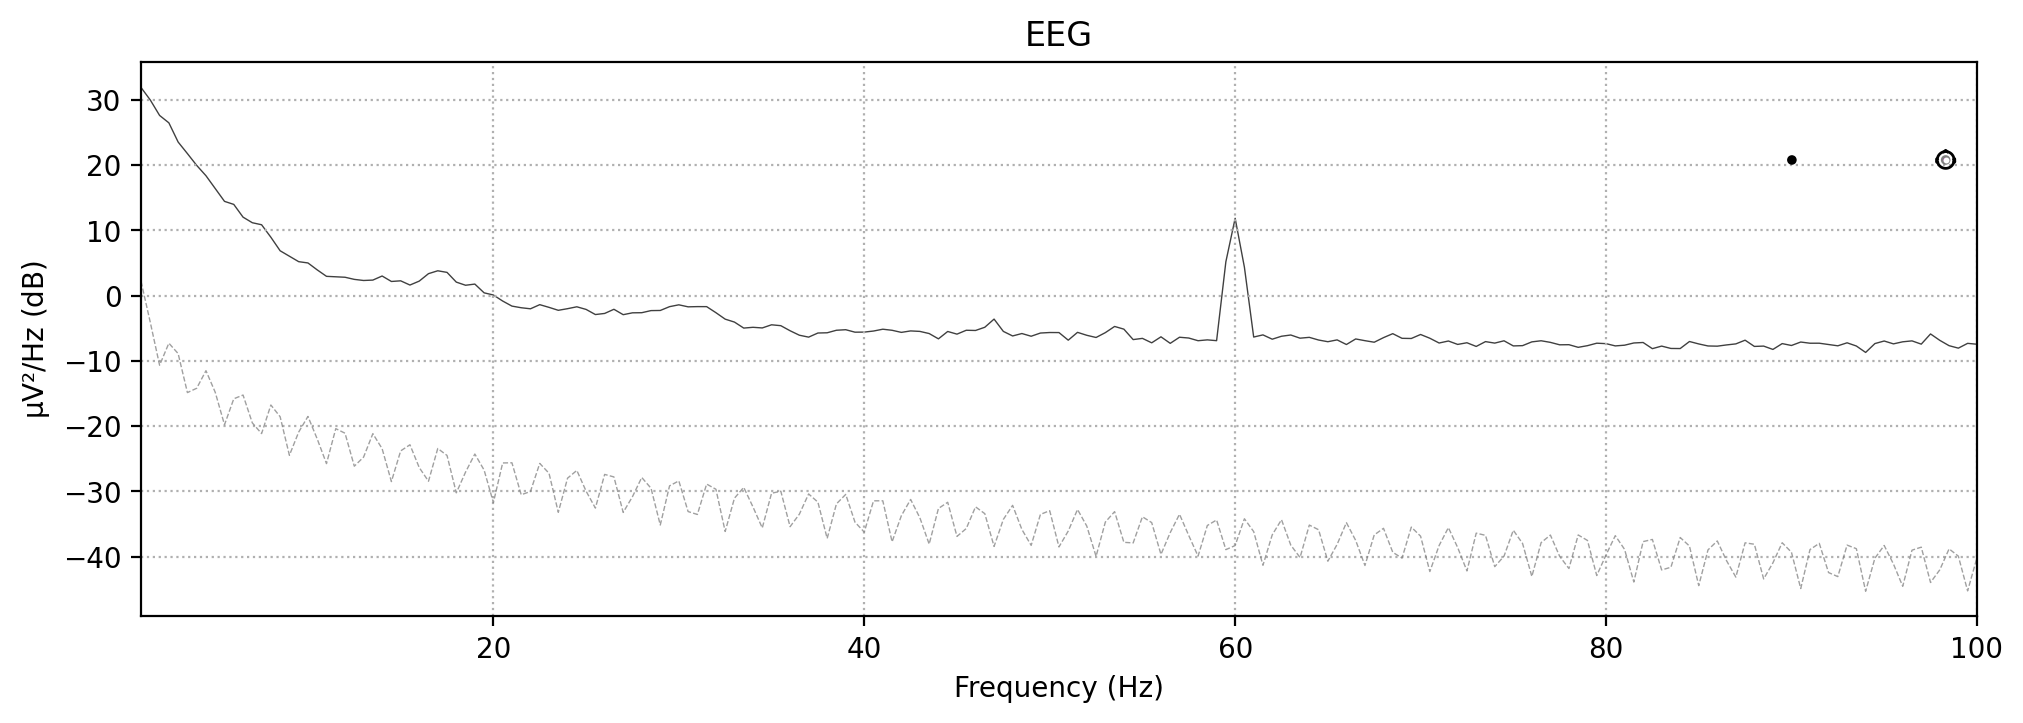

In [14]:
# Close eyes and open eyes

# noNotch
noNotch_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR/ Path('n_eyeOpen_2min_new_noNotch.fif'), preload=True)
# Check whether the ch exists
print(noNotch_raw_fif.info['ch_names'])
print(noNotch_raw_fif.get_channel_types())
# Rename the channels
noNotch_raw_fif.rename_channels({'Fz_1': 'Fz_1'})
noNotch_raw_fif.set_channel_types({'Fz_1': 'eeg'})


#Notched
Notched_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR / Path('n_eyeOpen_2min_new_Notched.fif'), preload=True)
# Check whether the ch exists
print(Notched_raw_fif.info['ch_names'])
print(Notched_raw_fif.get_channel_types())
# Rename the channels
Notched_raw_fif.rename_channels({'Fz_1': 'Fz_1'})
Notched_raw_fif.set_channel_types({'Fz_1': 'eeg'})

merged_LIST = [noNotch_raw_fif, Notched_raw_fif]
#merged_MMN_LIST.plot()

merged_raw = mne.concatenate_raws(merged_LIST)
merged_raw.compute_psd(fmin=1, fmax=100).plot()
#merged_raw.save(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), overwrite=True)

In [18]:
psd = merged_raw.compute_psd(fmin=0, fmax=100, picks='Fz_1')
freqs = psd.freqs
power = psd.get_data()[0]
"""
# Convert to dB
power_db = 10 * np.log10(power)

plt.semilogy(freqs, power, label='µV²/Hz')
plt.plot(freqs, power_db, label='dB (µV²/Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()
"""

"""
# Linear-log plot of PSD in µV²/Hz
plt.figure()
plt.semilogy(freqs, power, label='PSD (µV²/Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.show()

# dB plot
plt.figure()
plt.plot(freqs, power_db, label='PSD (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB, µV²/Hz)')
plt.legend()
plt.show()
"""


# Dual Y-Axis in One Plot
fig, ax1 = plt.subplots()

ax1.semilogy(freqs, power, color='blue', label='µV²/Hz')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power (µV²/Hz)', color='blue')

ax2 = ax1.twinx()
ax2.plot(freqs, power_db, color='red', label='dB (µV²/Hz)')
ax2.set_ylabel('Power (dB)', color='red')

plt.title('PSD in Linear and dB Scales')
plt.show()

Effective window size : 2.000 (s)


In [30]:
# Example: each of these is shape (n_freqs,)

# Input 2 type of gel and it's Eye Open & Close conditions
# Orig
orig_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
orig_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_orig = orig_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_orig = orig_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
# New 
new_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeClose_2min_merged_raw.fif'), preload=True)
new_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_new = new_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_new = new_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')



# If you still have epoch-wise PSD (n_epochs, n_freqs), do .mean(axis=0)
power_eyeC_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeC_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new.get_data(picks='Fz_1')).mean(axis=0)

freqs = psd_eyeC_orig.freqs  # shared frequency axis

# Linear-log plot of PSD in µV²/Hz
# PSD in µV²/Hz
plt.figure(figsize=(10,6))

plt.semilogy(freqs, power_eyeC_orig, color='blue',  linestyle='-',  label='Eyes Closed – Orig Gel')
plt.semilogy(freqs, power_eyeO_orig, color='blue',  linestyle='--', label='Eyes Open – Orig Gel')
plt.semilogy(freqs, power_eyeC_new,  color='orange', linestyle='-',  label='Eyes Closed – New Gel')
plt.semilogy(freqs, power_eyeO_new,  color='orange', linestyle='--', label='Eyes Open – New Gel')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.title('PSD Comparison (Fz_1)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeClose_2min_merged_raw.fif...
    Range : 152249 ... 423888 =    148.681 ...   413.953 secs
Ready.
Reading 0 ... 271639  =      0.000 ...   265.272 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeOpen_2min_merged_raw.fif...
    Range : 16358 ... 277490 =     15.975 ...   270.986 secs
Ready.
Reading 0 ... 261132  =      0.000 ...   255.012 secs...
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeClose_2min_merged_raw.fif...
    Range : 149443 ... 408140 =    145.940 ...   398.574 secs
Ready.
Reading 0 ... 258697  =      0.000 ...   252.634 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeOpen_2min_merged_raw.fif...
    Range : 15330 ... 284221 =     14.9

In [55]:
# Example: each of these is shape (n_freqs,)

# Input 2 type of gel and it's Eye Open & Close conditions
# Orig
orig_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
orig_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_orig = orig_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_orig = orig_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
# New 
new_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeClose_2min_merged_raw.fif'), preload=True)
new_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_new = new_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_new = new_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')


# If you still have epoch-wise PSD (n_epochs, n_freqs), do .mean(axis=0)
power_eyeC_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeC_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new.get_data(picks='Fz_1')).mean(axis=0)
"""
# Example: from Spectrum object
P_eyeC_orig = np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1')).mean(axis=0)
P_eyeO_orig = np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1')).mean(axis=0)
P_eyeC_new  = np.squeeze(psd_eyeC_new.get_data(picks='Fz_1')).mean(axis=0)
P_eyeO_new  = np.squeeze(psd_eyeO_new.get_data(picks='Fz_1')).mean(axis=0)
"""
freqs = psd_eyeC_orig.freqs
eps = 1e-20  # avoid log of zero

# Convert to dB
power_db_eyeC_orig = 10 * np.log10(np.maximum(power_eyeC_orig, eps))
power_db_eyeO_orig = 10 * np.log10(np.maximum(power_eyeO_orig, eps))
power_db_eyeC_new  = 10 * np.log10(np.maximum(power_eyeC_new, eps))
power_db_eyeO_new  = 10 * np.log10(np.maximum(power_eyeO_new, eps))

# Plot the dB power
plt.figure(figsize=(10,6))

# Plot all 4 conditions in dB
plt.plot(freqs, power_db_eyeC_orig, color='blue',  linestyle='-',  label='Eyes Closed – Orig Gel')
plt.plot(freqs, power_db_eyeO_orig, color='blue',  linestyle='--', label='Eyes Open – Orig Gel')
plt.plot(freqs, power_db_eyeC_new,  color='green', linestyle='-',  label='Eyes Closed – New Gel')
plt.plot(freqs, power_db_eyeO_new,  color='green', linestyle='--', label='Eyes Open – New Gel')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB, µV²/Hz)')
plt.title('PSD Comparison in dB (Fz_1)')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeClose_2min_merged_raw.fif...
    Range : 152249 ... 423888 =    148.681 ...   413.953 secs
Ready.
Reading 0 ... 271639  =      0.000 ...   265.272 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeOpen_2min_merged_raw.fif...
    Range : 16358 ... 277490 =     15.975 ...   270.986 secs
Ready.
Reading 0 ... 261132  =      0.000 ...   255.012 secs...
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeClose_2min_merged_raw.fif...
    Range : 149443 ... 408140 =    145.940 ...   398.574 secs
Ready.
Reading 0 ... 258697  =      0.000 ...   252.634 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeOpen_2min_merged_raw.fif...
    Range : 15330 ... 284221 =     14.9

In [56]:
# 1) Helpers: safe shaping + SNR
import numpy as np

def ensure_2d(P):
    """
    Ensure PSD array is 2-D: (n_epochs, n_freqs).
    Accepts (n_epochs, n_freqs) or (n_freqs,).
    """
    P = np.asarray(P)
    if P.ndim == 1:
        P = P[None, :]
    elif P.ndim != 2:
        raise ValueError(f"Unexpected PSD shape {P.shape}")
    return P

def band_mean(P, freqs, fmin, fmax):
    """Mean PSD in a band (µV²/Hz), returned per epoch."""
    P = ensure_2d(P)                          # (n_epochs, n_freqs)
    idx = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(idx):
        raise ValueError(f"No bins in [{fmin}, {fmax}] Hz.")
    return P[:, idx].mean(axis=1)             # (n_epochs,)

def snr_db_from_psd(P, freqs, signal_band=(8,12), noise_band=(45,55)):
    """
    SNR(dB) = 10*log10( mean(signal_band) / mean(noise_band) )
    P can be (n_epochs, n_freqs) or (n_freqs,).
    """
    sig = band_mean(P, freqs, *signal_band)
    noi = band_mean(P, freqs, *noise_band)
    eps = 1e-20
    return 10 * np.log10( (sig + eps) / (noi + eps) )   # (n_epochs,)

# 2) Pull PSDs per condition and compute SNR(dB)

# Input 2 type of gel and it's Eye Open & Close conditions
# Orig
orig_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
orig_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_orig = orig_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_orig = orig_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
# New 
new_eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeClose_2min_merged_raw.fif'), preload=True)
new_eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_new = new_eyeC_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_new = new_eyeO_merged_fif.compute_psd(fmin=0, fmax=100, picks='Fz_1')
"""
# If you still have epoch-wise PSD (n_epochs, n_freqs), do .mean(axis=0)
power_eyeC_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeC_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new.get_data(picks='Fz_1')).mean(axis=0)
"""

# From your Spectrum objects (computed via .compute_psd), get per-epoch PSDs:
# (they become (n_epochs, n_freqs) after squeeze for a single channel)
P_CE_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1'))
P_OE_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1'))
P_CE_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new .get_data(picks='Fz_1'))
P_OE_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new .get_data(picks='Fz_1'))

freqs = psd_eyeC_orig.freqs

# Choose bands
signal_band = (8, 12)    # alpha
noise_band  = (55, 65)   # adjust if needed (50 Hz region or 60 Hz region)

# Compute SNR per epoch (dB)
snr_CE_orig = snr_db_from_psd(P_CE_orig, freqs, signal_band, noise_band)
snr_OE_orig = snr_db_from_psd(P_OE_orig, freqs, signal_band, noise_band)
snr_CE_new  = snr_db_from_psd(P_CE_new,  freqs, signal_band, noise_band)
snr_OE_new  = snr_db_from_psd(P_OE_new,  freqs, signal_band, noise_band)


# 3) Stats (within‑gel CE vs OE; within‑eye Orig vs New)
from scipy.stats import ttest_ind, ttest_rel

paired = False  # set True only if your CE/OE epochs are one-to-one paired

def t_compare(a, b, lbl):
    if len(a) > 1 and len(b) > 1:
        if paired and len(a) == len(b):
            t, p = ttest_rel(a, b)
            test = "paired t"
        else:
            t, p = ttest_ind(a, b, equal_var=False)
            test = "Welch t"
        print(f"{lbl}: {test}: t={t:.2f}, p={p:.4g}")
    else:
        print(f"{lbl}: only one spectrum → no t-test")

print("Alpha SNR(dB) comparisons:")
t_compare(snr_CE_orig, snr_OE_orig, "Orig Gel  (EC vs EO)")
t_compare(snr_CE_new,  snr_OE_new,  "New  Gel  (EC vs EO)")
t_compare(snr_CE_orig, snr_CE_new,  "Eyes Closed (Orig vs New)")
t_compare(snr_OE_orig, snr_OE_new,  "Eyes Open   (Orig vs New)")

# 4) Bar plot (mean ± SEM) for the 4 cells
import matplotlib.pyplot as plt

conds   = ["EC Orig", "EO Orig", "EC New", "EO New"]
snr_all = [snr_CE_orig, snr_OE_orig, snr_CE_new, snr_OE_new]
print(snr_all)

means = [x.mean() for x in snr_all]
sems  = [x.std(ddof=1)/np.sqrt(len(x)) if len(x)>1 else np.nan for x in snr_all]

plt.figure(figsize=(8,5))
bars = plt.bar(conds, means, yerr=sems, capsize=4, color=['#1f77b4','#1f77b4','#2ca02c','#2ca02c'])
for i,b in enumerate(bars):
    b.set_alpha(0.9 if i%2==0 else 0.5)  # solid=CE, lighter=OE
plt.ylabel('Alpha SNR (dB)')
plt.title(f'Alpha SNR by Eye × Gel (Fz_1), noise={noise_band[0]}–{noise_band[1]} Hz)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeClose_2min_merged_raw.fif...
    Range : 152249 ... 423888 =    148.681 ...   413.953 secs
Ready.
Reading 0 ... 271639  =      0.000 ...   265.272 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeOpen_2min_merged_raw.fif...
    Range : 16358 ... 277490 =     15.975 ...   270.986 secs
Ready.
Reading 0 ... 261132  =      0.000 ...   255.012 secs...
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeClose_2min_merged_raw.fif...
    Range : 149443 ... 408140 =    145.940 ...   398.574 secs
Ready.
Reading 0 ... 258697  =      0.000 ...   252.634 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeOpen_2min_merged_raw.fif...
    Range : 15330 ... 284221 =     14.9

In [57]:
# Alpha SNR and its power
# 1) Helper: compute SNR from a Raw object
import numpy as np

def snr_db_from_raw(raw, pick='Fz_1',
                    fmin=1, fmax=70,
                    signal_band=(8, 12),
                    noise_band=(45, 55),
                    method='welch'):
    """
    Compute SNR(dB) = 10*log10( mean PSD in signal_band / mean PSD in noise_band )
    directly from an MNE Raw object, single channel.
    Returns: snr_db, freqs, psd_1d (µV²/Hz), sig_mean, noise_mean
    """
    spec = raw.compute_psd(fmin=fmin, fmax=fmax, method=method, picks=pick)
    freqs = spec.freqs
    P = np.squeeze(spec.get_data())  # (n_freqs,) for one channel

    # Pick bands
    sidx = (freqs >= signal_band[0]) & (freqs <= signal_band[1])
    nidx = (freqs >= noise_band[0])  & (freqs <= noise_band[1])
    if not np.any(sidx):
        raise ValueError(f"No bins inside signal band {signal_band}.")
    if not np.any(nidx):
        raise ValueError(f"No bins inside noise band {noise_band}.")

    sig = P[sidx].mean()
    noi = P[nidx].mean()
    snr_db = 10 * np.log10((sig + 1e-20) / (noi + 1e-20))
    return snr_db, freqs, P, sig, noi

# 2) Run it for the 4 raw conditions
# Prepare your four Raw objects (single channel available inside each):
# raw_eyeC_orig, raw_eyeO_orig, raw_eyeC_new, raw_eyeO_new

# Input 2 type of gel and it's Eye Open & Close conditions
# Orig
raw_eyeC_orig = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
raw_eyeO_orig = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_orig = raw_eyeC_orig.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_orig = raw_eyeO_orig.compute_psd(fmin=0, fmax=100, picks='Fz_1')
# New 
raw_eyeC_new = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeClose_2min_merged_raw.fif'), preload=True)
raw_eyeO_new = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), preload=True)
psd_eyeC_new = raw_eyeC_new.compute_psd(fmin=0, fmax=100, picks='Fz_1')
psd_eyeO_new = raw_eyeO_new.compute_psd(fmin=0, fmax=100, picks='Fz_1')
"""
# If you still have epoch-wise PSD (n_epochs, n_freqs), do .mean(axis=0)
power_eyeC_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1')).mean(axis=0)
power_eyeC_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new.get_data(picks='Fz_1')).mean(axis=0)
power_eyeO_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new.get_data(picks='Fz_1')).mean(axis=0)
"""
# From your Spectrum objects (computed via .compute_psd), get per-epoch PSDs:
# (they become (n_epochs, n_freqs) after squeeze for a single channel)
P_CE_orig = psd_eyeC_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_orig.get_data(picks='Fz_1'))
P_OE_orig = psd_eyeO_orig.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_orig.get_data(picks='Fz_1'))
P_CE_new  = psd_eyeC_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeC_new .get_data(picks='Fz_1'))
P_OE_new  = psd_eyeO_new.get_data(picks='Fz_1')[0] #np.squeeze(psd_eyeO_new .get_data(picks='Fz_1'))

# Calculate the alpha and the noise
signal_band = (8, 12)       # alpha
noise_band  = (55, 65)      # tweak to your mains neighborhood
pick = 'Fz_1'

snr_CE_orig, f1, P_CE_orig, sig_CE_orig, noi_CE_orig = snr_db_from_raw(
    raw_eyeC_orig, pick=pick, signal_band=signal_band, noise_band=noise_band
)
snr_OE_orig, f2, P_OE_orig, sig_OE_orig, noi_OE_orig = snr_db_from_raw(
    raw_eyeO_orig, pick=pick, signal_band=signal_band, noise_band=noise_band
)
snr_CE_new,  f3, P_CE_new,  sig_CE_new,  noi_CE_new  = snr_db_from_raw(
    raw_eyeC_new,  pick=pick, signal_band=signal_band, noise_band=noise_band
)
snr_OE_new,  f4, P_OE_new,  sig_OE_new,  noi_OE_new  = snr_db_from_raw(
    raw_eyeO_new,  pick=pick, signal_band=signal_band, noise_band=noise_band
)

print(f"Alpha SNR (dB) — CE Orig: {snr_CE_orig:.2f}, OE Orig: {snr_OE_orig:.2f}, "
      f"CE New: {snr_CE_new:.2f}, OE New: {snr_OE_new:.2f}")
"""
# 3) Optional: 60 Hz‑specific SNR
#If you specifically want “alpha vs. 60 Hz bin”:
# Use it on each pair (freqs, P_*).

def snr_vs_60hz_db(freqs, P, signal_band=(8,12), hz=60):
    sidx = (freqs >= signal_band[0]) & (freqs <= signal_band[1])
    sig  = P[sidx].mean()
    bin60 = np.argmin(np.abs(freqs - hz))
    noi  = P[bin60]
    return 10*np.log10((sig + 1e-20) / (noi + 1e-20))

"""
# 4) Quick plot (all four PSDs, µV²/Hz)
import matplotlib.pyplot as plt

freqs = f1  # assume identical grids; if not, interpolate to common grid
plt.figure(figsize=(10,6))
plt.semilogy(freqs, P_CE_orig, color='blue',  linestyle='-',  label=f'CE Orig (SNR {snr_CE_orig:.1f} dB)')
plt.semilogy(freqs, P_OE_orig, color='blue',  linestyle='--', label=f'OE Orig (SNR {snr_OE_orig:.1f} dB)')
plt.semilogy(freqs, P_CE_new,  color='green', linestyle='-',  label=f'CE New  (SNR {snr_CE_new:.1f} dB)')
plt.semilogy(freqs, P_OE_new,  color='green', linestyle='--', label=f'OE New  (SNR {snr_OE_new:.1f} dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.title(f'Raw PSD and Alpha SNR (band={signal_band[0]}–{signal_band[1]} Hz, noise={noise_band[0]}–{noise_band[1]} Hz)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeClose_2min_merged_raw.fif...
    Range : 152249 ... 423888 =    148.681 ...   413.953 secs
Ready.
Reading 0 ... 271639  =      0.000 ...   265.272 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeOpen_2min_merged_raw.fif...
    Range : 16358 ... 277490 =     15.975 ...   270.986 secs
Ready.
Reading 0 ... 261132  =      0.000 ...   255.012 secs...
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeClose_2min_merged_raw.fif...
    Range : 149443 ... 408140 =    145.940 ...   398.574 secs
Ready.
Reading 0 ... 258697  =      0.000 ...   252.634 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_new_eyeOpen_2min_merged_raw.fif...
    Range : 15330 ... 284221 =     14.9

In [58]:
# Change from alpha SNR to dB
import numpy as np
import matplotlib.pyplot as plt

# ---- CONFIG ----
signal_band = (8, 12)     # alpha
noise_band  = (55, 65)    # adjust for your mains neighborhood (e.g., 48–52 for 50 Hz)
eps = 1e-20

def snr_alpha_db(freqs, P, sig_band=signal_band, noi_band=noise_band):
    """SNR(dB) = 10*log10(mean(PSD in alpha) / mean(PSD in noise band))."""
    sidx = (freqs >= sig_band[0]) & (freqs <= sig_band[1])
    nidx = (freqs >= noi_band[0]) & (freqs <= noi_band[1])
    sig  = np.mean(P[sidx])
    noi  = np.mean(P[nidx])
    return 10*np.log10((sig + eps) / (noi + eps))

# Convert the four PSDs (µV²/Hz) to dB for plotting
Pdb_CE_orig = 10*np.log10(np.maximum(P_CE_orig, eps))
Pdb_OE_orig = 10*np.log10(np.maximum(P_OE_orig, eps))
Pdb_CE_new  = 10*np.log10(np.maximum(P_CE_new,  eps))
Pdb_OE_new  = 10*np.log10(np.maximum(P_OE_new,  eps))

# Alpha SNR (dB) for the four conditions
snr_CE_orig = snr_alpha_db(freqs, P_CE_orig)
snr_OE_orig = snr_alpha_db(freqs, P_OE_orig)
snr_CE_new  = snr_alpha_db(freqs, P_CE_new)
snr_OE_new  = snr_alpha_db(freqs, P_OE_new)

# ---- PLOT: top = PSD in dB; bottom = bar chart of alpha SNR(dB) ----
fig = plt.figure(figsize=(11, 7))
gs = fig.add_gridspec(2, 1, height_ratios=[2.3, 1.0], hspace=0.28)

# Top: dB PSD curves
ax = fig.add_subplot(gs[0])

ax.plot(freqs, Pdb_CE_orig, color='blue',  linestyle='-',  label=f'CE Orig')
ax.plot(freqs, Pdb_OE_orig, color='blue',  linestyle='--', label=f'OE Orig')
ax.plot(freqs, Pdb_CE_new,  color='green', linestyle='-',  label=f'CE New')
ax.plot(freqs, Pdb_OE_new,  color='green', linestyle='--', label=f'OE New')

# Shade alpha and noise bands
ax.axvspan(signal_band[0], signal_band[1], color='gray', alpha=0.15, label='Alpha band')
ax.axvspan(noise_band[0],  noise_band[1],  color='red',  alpha=0.08, label='Noise band')

ax.set_xlim(freqs[0], freqs[-1])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB, µV²/Hz)')
ax.set_title('PSD in dB with Alpha & Noise Bands (Fz_1)')
# Build a single legend without duplicate labels
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc='best', fontsize=9)
ax.grid(True, ls='--', alpha=0.4)

# Bottom: Alpha SNR bars
axb = fig.add_subplot(gs[1])

conds = ["CE Orig", "OE Orig", "CE New", "OE New"]
snr_vals = [snr_CE_orig, snr_OE_orig, snr_CE_new, snr_OE_new]
print(snr_vals)
colors = ['#1f77b4', '#1f77b480', '#2ca02c', '#2ca02c80']  # solid vs dashed effect via alpha

bars = axb.bar(conds, snr_vals, color=colors)
axb.set_ylabel('Alpha SNR (dB)')
axb.set_title('Alpha SNR by Condition')
axb.grid(axis='y', alpha=0.3)

# Annotate values on bars
for b, v in zip(bars, snr_vals):
    axb.text(b.get_x() + b.get_width()/2, b.get_height() + 0.2, f'{v:.1f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


[7.491288305935827, 8.761761700088673, -5.5939806458592, 4.639319557398341]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/2292179245.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
# Orig
eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeOpen_2min_merged_raw.fif'), preload=True)
# New 
#eyeC_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeClose_2min_merged_raw.fif'), preload=True)
#eyeO_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_new_eyeOpen_2min_merged_raw.fif'), preload=True)

In [7]:
# Creating the new epochs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
fiveTask_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('n_orig_eyeClose_2min_merged_raw.fif'), preload=True)
fiveTask_merged_fif.plot()

# Set the event markers according to the annotations
fiveTask_eventsArray = mne.events_from_annotations(fiveTask_merged_fif)[0]
print(fiveTask_eventsArray)

fiveTask_events = fiveTask_eventsArray #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
#fiveTask_event_id = {'start':2} #, 'end':55} # eye close 
fiveTask_event_id = {'start':1} #, 'end':55} # eye open

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 2 # for 2 seconds          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

fivetasks_epoch_DIR = fif_DIR / '5tasks_epochs'
fivetasks_epoch_DIR.mkdir(exist_ok=True)
#fiveTask_merged_fif.filter(0, 70, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_5tasks = mne.Epochs(fiveTask_merged_fif, fiveTask_events, fiveTask_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_5tasks.info)
#n_epoch_5tasks.save(fivetasks_epoch_DIR / Path('n_orig_eyeClose_2min_nofilter_epochs.fif'), overwrite=True)
n_epoch_5tasks

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/n_orig_eyeClose_2min_merged_raw.fif...
    Range : 152249 ... 423888 =    148.681 ...   413.953 secs
Ready.
Reading 0 ... 271639  =      0.000 ...   265.272 secs...
Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['2', '21', '55']
[[152454      0      1]
 [215433      0      2]
 [286392      0      3]
 [287110      0      1]
 [350088      0      2]
 [423376      0      3]]
Not setting metadata
2 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 2151 original time points ...
0 bad epochs dropped
<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 07:24:31 UTC


Number of events,2
Events,start: 2
Time range,-0.100 – 2.000 s
Baseline,-0.100 – 0.000 s


Channels marked as bad:
['Trigger']


Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_new_eyeOpen_2min_nofilter_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/2313575140.py:1: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_new_eyeOpen_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  n_eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)


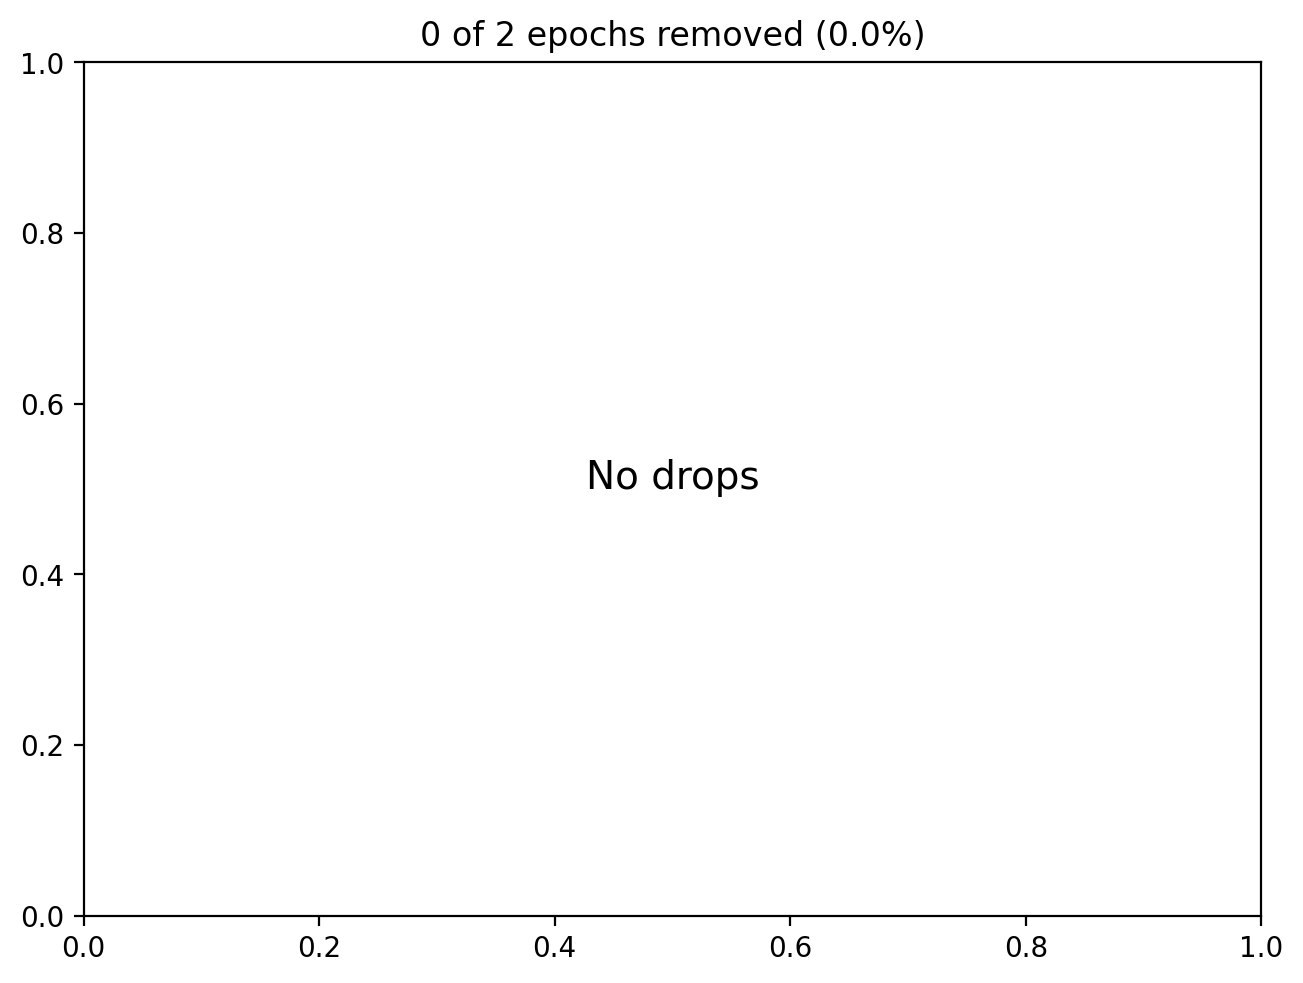

In [135]:
n_eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
n_eyeO_epoch
n_eyeO_epoch.plot_drop_log()

In [12]:
import numpy as np
import matplotlib.pyplot as plt


## Import epochs
# Original gel
eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_orig_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_orig_eyeClose_2min_nofilter_epochs.fif'), preload=True)
# New gel
#eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
#eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_new_eyeClose_2min_nofilter_epochs.fif'), preload=True)


# Step 1: Compute PSD for each condition
psd_ce = eyeO_epoch.compute_psd(fmin=0.5, fmax=45) #, method='welch')
psd_oe = eyeC_epoch.compute_psd(fmin=0.5, fmax=45) #, method='welch')

# Step 2: Extract frequency and power arrays
freqs = psd_ce.freqs
power_ce = psd_ce.get_data(picks='Fz_1')  # shape (n_epochs, n_freqs)
power_oe = psd_oe.get_data(picks='Fz_1')

# Step 3: Define frequency band indices
band_ranges = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (13, 30),
    'Gamma': (30, 45),
}

# Step 4: Compute mean power per band
band_power_ce = []
band_power_oe = []

# Squeeze out the single channel dimension
power_ce = np.squeeze(power_ce)  # shape: (n_epochs, n_freqs)
power_oe = np.squeeze(power_oe)


for band, (fmin, fmax) in band_ranges.items():
    idx = (freqs >= fmin) & (freqs < fmax)
    band_ce = power_ce[:, idx].mean()
    band_oe = power_oe[:, idx].mean()
    band_power_ce.append(band_ce)
    band_power_oe.append(band_oe)

print("power_ce shape:", power_ce.shape)  # should be (n_epochs, n_freqs)
print("freqs shape:", freqs.shape)        # should be (n_freqs,)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_orig_eyeOpen_2min_nofilter_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_orig_eyeClose_2min_nofilter_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
power_ce shape: (2, 93)
freqs shape: (93,)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3095131563.py:7: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_orig_eyeOpen_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_orig_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3095131563.py:8: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/n_orig_eyeClose_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('n_orig_eyeClose_2min_nofilter_epochs.fif'), preload=True)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel

# --- inputs you already have ---
# eyeO_epoch, eyeC_epoch  (MNE Epochs)
# channel name: 'Fz_1' (adjust if needed)

# PSD (Welch/multitaper per-epoch). Keep 0–45 Hz by default.
psd_ce = eyeC_epoch.compute_psd(fmin=0.5, fmax=45)  # CE
psd_oe = eyeO_epoch.compute_psd(fmin=0.5, fmax=45)  # OE

freqs = psd_ce.freqs
# shape -> (n_epochs, n_channels=1, n_freqs) when you pick a single channel
P_ce = np.squeeze(psd_ce.get_data(picks='Fz_1'))  # (n_epochs, n_freqs)
P_oe = np.squeeze(psd_oe.get_data(picks='Fz_1'))  # (n_epochs, n_freqs)

# Safety (no zeros before log)
eps = 1e-20

# Band definitions (Hz)
band_ranges = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta' : (13, 30),
    'Gamma': (30, 45),
}

# Integrate PSD over each band to get band power in µV², then convert to dB
def bandpower_db(P, freqs, fmin, fmax):
    idx = (freqs >= fmin) & (freqs <= fmax)
    # Integrate PSD over frequency -> µV² (use trapezoid integration for proper Hz weighting)
    bp = np.trapz(P[:, idx], freqs[idx], axis=1)  # (n_epochs,)
    # Convert to dB(µV²)
    bp_db = 10 * np.log10(np.maximum(bp, eps))
    return bp_db

results = {'CE': {}, 'OE': {}}
for band, (fmin, fmax) in band_ranges.items():
    results['CE'][band] = bandpower_db(P_ce, freqs, fmin, fmax)
    results['OE'][band] = bandpower_db(P_oe, freqs, fmin, fmax)

# Quick sanity print
for band in band_ranges:
    print(f"{band}: CE mean={results['CE'][band].mean():.2f} dB, OE mean={results['OE'][band].mean():.2f} dB")


paired = False  # set True if epochs are one-to-one paired per band

print("\nBand-wise statistics (dB):")
for band in band_ranges:
    a = results['CE'][band]
    b = results['OE'][band]
    if paired and (len(a) == len(b)):
        t, p = ttest_rel(a, b)
        test_name = "paired t"
    else:
        t, p = ttest_ind(a, b, equal_var=False)
        test_name = "Welch t"
    print(f"{band}: {test_name}  t={t:.2f}, p={p:.4g}")


bands = list(band_ranges.keys())
CE_means = [results['CE'][b].mean() for b in bands]
OE_means = [results['OE'][b].mean() for b in bands]
CE_sems  = [results['CE'][b].std(ddof=1)/np.sqrt(len(results['CE'][b])) for b in bands]
OE_sems  = [results['OE'][b].std(ddof=1)/np.sqrt(len(results['OE'][b])) for b in bands]

x = np.arange(len(bands))
w = 0.38

plt.figure(figsize=(10,6))
plt.bar(x - w/2, CE_means, w, yerr=CE_sems, capsize=4, label='Eyes Closed')
plt.bar(x + w/2, OE_means, w, yerr=OE_sems, capsize=4, label='Eyes Open')
plt.xticks(x, bands)
plt.ylabel('Band power (dB, µV²)')
plt.title('Band power by condition at Fz_1')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# plt.savefig('bandpower_dB_Fz1_CE_vs_OE.png', dpi=300)


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Delta: CE mean=-72.48 dB, OE mean=-67.11 dB
Theta: CE mean=-82.03 dB, OE mean=-77.42 dB
Alpha: CE mean=-84.67 dB, OE mean=-82.02 dB
Beta: CE mean=-80.41 dB, OE mean=-80.98 dB
Gamma: CE mean=-84.12 dB, OE mean=-85.44 dB

Band-wise statistics (dB):
Delta: Welch t  t=-0.51, p=0.663
Theta: Welch t  t=-0.54, p=0.6841
Alpha: Welch t  t=-0.72, p=0.5573
Beta: Welch t  t=0.13, p=0.911
Gamma: Welch t  t=0.34, p=0.7711


In [9]:
## Eye Open & Close comparison under 4 diff freq bands
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data

channel = 'Fz_1'
epoch_idx = 0
bands = {
    'δ (0.5–4 Hz)' : (0.5, 4),
    'θ (4–8 Hz)'   : (4, 8),
    'α (8–12 Hz)'  : (8, 12),
    'β (13–30 Hz)' : (13, 30),
}

# Extract one epoch from each condition
x_O = eyeO_epoch.get_data(picks=channel)[epoch_idx, 0, :]
x_C = eyeC_epoch.get_data(picks=channel)[epoch_idx, 0, :]
times = eyeO_epoch.times
sfreq = eyeO_epoch.info['sfreq']

n = len(bands)
plt.figure(figsize=(12, 2.2*n))

for i, (name, (fmin, fmax)) in enumerate(bands.items(), start=1):
    yO = filter_data(x_O.copy(), sfreq, fmin, fmax, method='fir', phase='zero')
    yC = filter_data(x_C.copy(), sfreq, fmin, fmax, method='fir', phase='zero')

    # normalize each to a.u. for visual comparability
    yO = yO / (np.std(yO) + 1e-12)
    yC = yC / (np.std(yC) + 1e-12)

    ax = plt.subplot(n, 1, i)
    ax.plot(times, yC, label='Eyes Closed', linewidth=1.5)
    ax.plot(times, yO, label='Eyes Open', linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.set_ylabel('a.u.')
    ax.grid(True, axis='x')
    if i == n:
        ax.set_xlabel('Time (s)')
    if i == 1:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
# plt.savefig('overlay_OE_CE_per_band.png', dpi=300)


Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/2931823998.py:24: RuntimeWarning: filter_length (6759) is longer than the signal (2151), distortion is likely. Reduce filter length or filter a longer signal.
  yO = filter_data(x_O.copy(), sfreq, fmin, fmax, method='fir', phase='zero')
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/2931823998.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (2151), distortion is likely. Reduce filter length or filter a longer signal.
  yC = filter_data(x_C.copy(), sfreq, fmin, fmax, method='fir', phase='zero')


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 1691 samples (1.651 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 1691 samples (1.651 s)

Setting up band-pass filter from 8 

In [144]:
## Eye Close All freq bands
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data
from scipy.signal import hilbert  # optional: smooth envelope

# ---------- Settings ----------
channel = 'Fz_1'
epoch_idx = 0                     # which epoch to visualize
bands = {
    'δ wave (0.5–4 Hz)': (0.5, 4),
    'θ wave (4–8 Hz)'  : (4, 8),
    'α wave (8–12 Hz)' : (8, 12),
    'β wave (13–30 Hz)': (13, 30),
}
use_envelope = False              # set True to plot amplitude envelopes
y_offset = 3.0                    # vertical spacing between traces

# ---------- Get one epoch & channel ----------
data = eyeC_epoch.get_data(picks=channel)[epoch_idx, 0, :]   # shape: (n_times,)
times = eyeC_epoch.times                                     # seconds
sfreq = eyeC_epoch.info['sfreq']

# ---------- Band-pass per band ----------
filtered = {}
for name, (fmin, fmax) in bands.items():
    x = filter_data(data.copy(), sfreq=sfreq, l_freq=fmin, h_freq=fmax,
                    method='fir', phase='zero')  # linear-phase for visualization
    if use_envelope:
        x = np.abs(hilbert(x))                   # optional amplitude envelope
    # normalize to a.u. for nicer stacking
    x = x / (np.std(x) + 1e-12)
    filtered[name] = x

# ---------- Plot like the paper (stacked) ----------
plt.figure(figsize=(10, 6))
colors = ['black', 'red', 'green', 'blue']
for i, (name, col) in enumerate(zip(filtered.keys(), colors)):
    offset = y_offset * (len(bands) - i - 1)
    plt.plot(times, filtered[name] + offset, color=col, linewidth=1.5, label=name)

plt.xlabel('Time (s)')
plt.ylabel('Signal (a.u.)')
plt.title(f'Band‑limited oscillations at {channel} (Eyes Closed, epoch {epoch_idx})')
plt.yticks([])               # hide y ticks to match “a.u.” style
plt.grid(True, axis='x')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
# plt.savefig('stacked_waves_eyeC.png', dpi=300)


Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/4262791244.py:26: RuntimeWarning: filter_length (6759) is longer than the signal (2151), distortion is likely. Reduce filter length or filter a longer signal.
  x = filter_data(data.copy(), sfreq=sfreq, l_freq=fmin, h_freq=fmax,



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1041 samples (1.017 s)



2025-08-23 17:48:16.899 python[38027:21351307] +[CATransaction synchronize] called within transaction


In [13]:
## Eye Open All freq bands
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data
from scipy.signal import hilbert  # optional: smooth envelope

# ---------- Settings ----------
channel = 'Fz_1'
epoch_idx = 0                     # which epoch to visualize
bands = {
    'δ wave (0.5–4 Hz)': (0.5, 4),
    'θ wave (4–8 Hz)'  : (4, 8),
    'α wave (8–12 Hz)' : (8, 12),
    'β wave (13–30 Hz)': (13, 30),
}
use_envelope = False              # set True to plot amplitude envelopes
y_offset = 3.0                    # vertical spacing between traces

# ---------- Get one epoch & channel ----------
data = eyeO_epoch.get_data(picks=channel)[epoch_idx, 0, :]   # shape: (n_times,)
times = eyeO_epoch.times                                     # seconds
sfreq = eyeO_epoch.info['sfreq']

# ---------- Band-pass per band ----------
filtered = {}
for name, (fmin, fmax) in bands.items():
    x = filter_data(data.copy(), sfreq=sfreq, l_freq=fmin, h_freq=fmax,
                    method='fir', phase='zero')  # linear-phase for visualization
    if use_envelope:
        x = np.abs(hilbert(x))                   # optional amplitude envelope
    # normalize to a.u. for nicer stacking
    x = x / (np.std(x) + 1e-12)
    filtered[name] = x

# ---------- Plot like the paper (stacked) ----------
plt.figure(figsize=(10, 6))
colors = ['black', 'red', 'green', 'blue']
for i, (name, col) in enumerate(zip(filtered.keys(), colors)):
    offset = y_offset * (len(bands) - i - 1)
    plt.plot(times, filtered[name] + offset, color=col, linewidth=1.5, label=name)

plt.xlabel('Time (s)')
plt.ylabel('Signal (a.u.)')
plt.title(f'Band‑limited oscillations at {channel} (Eyes Open, epoch {epoch_idx})')
plt.yticks([])               # hide y ticks to match “a.u.” style
plt.grid(True, axis='x')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
# plt.savefig('stacked_waves_eyeC.png', dpi=300)


Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_53445/3767789003.py:27: RuntimeWarning: filter_length (6759) is longer than the signal (2151), distortion is likely. Reduce filter length or filter a longer signal.
  x = filter_data(data.copy(), sfreq=sfreq, l_freq=fmin, h_freq=fmax,
2025-08-23 20:58:49.314 python[53445:21745366] +[CATransaction synchronize] called within transaction
